In [ ]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras.layers import Dense, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Conv2D, Dropout, Flatten
import time
from tensorflow.keras.models import Sequential

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
generator = Sequential(name='generator')

generator.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Reshape((7, 7, 256)))
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

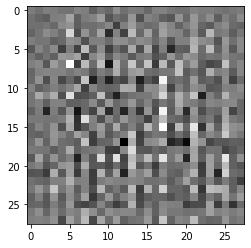

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = Sequential(name='discriminator')
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0016649]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
os.mkdir('images')
checkpoint_dir = './training_checkpoints'

In [ ]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  save_path = 'images/' + 'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(save_path)

  plt.show()

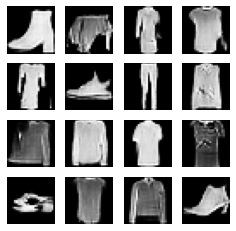

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
!zip -r images.zip images

updating: images/ (stored 0%)
  adding: images/image_at_epoch_0530.png (deflated 5%)
  adding: images/image_at_epoch_0016.png (deflated 6%)
  adding: images/image_at_epoch_0497.png (deflated 5%)
  adding: images/image_at_epoch_0520.png (deflated 5%)
  adding: images/image_at_epoch_0375.png (deflated 5%)
  adding: images/image_at_epoch_0253.png (deflated 5%)
  adding: images/image_at_epoch_0366.png (deflated 5%)
  adding: images/image_at_epoch_0429.png (deflated 5%)
  adding: images/image_at_epoch_0825.png (deflated 5%)
  adding: images/image_at_epoch_0992.png (deflated 5%)
  adding: images/image_at_epoch_0714.png (deflated 5%)
  adding: images/image_at_epoch_0730.png (deflated 5%)
  adding: images/image_at_epoch_0837.png (deflated 6%)
  adding: images/image_at_epoch_0077.png (deflated 6%)
  adding: images/image_at_epoch_0905.png (deflated 5%)
  adding: images/image_at_epoch_0885.png (deflated 5%)
  adding: images/image_at_epoch_0701.png (deflated 5%)
  adding: images/image_at_epoch_026

In [ ]:
!zip -r checkpoints.zip training_checkpoints

  adding: training_checkpoints/ (stored 0%)
  adding: training_checkpoints/ckpt-53.index (deflated 71%)
  adding: training_checkpoints/ckpt-43.data-00000-of-00001 (deflated 8%)
  adding: training_checkpoints/ckpt-36.data-00000-of-00001 (deflated 8%)
  adding: training_checkpoints/ckpt-22.data-00000-of-00001 (deflated 8%)
  adding: training_checkpoints/ckpt-65.data-00000-of-00001 (deflated 8%)
  adding: training_checkpoints/ckpt-64.index (deflated 71%)
  adding: training_checkpoints/ckpt-8.data-00000-of-00001 (deflated 9%)
  adding: training_checkpoints/ckpt-61.index (deflated 71%)
  adding: training_checkpoints/ckpt-6.data-00000-of-00001 (deflated 9%)
  adding: training_checkpoints/ckpt-52.index (deflated 71%)
  adding: training_checkpoints/ckpt-3.index (deflated 71%)
  adding: training_checkpoints/ckpt-13.index (deflated 71%)
  adding: training_checkpoints/ckpt-55.index (deflated 71%)
  adding: training_checkpoints/ckpt-54.index (deflated 71%)
  adding: training_checkpoints/ckpt-25.in